In [41]:
# automatically show plots inside the notebook
%matplotlib inline  

# reload all modules before executing code
%load_ext autoreload
%autoreload 2  

# import statements go here
import torch
import torch.nn as nn
import torch.tensor as tensor 
import librosa
import numpy as np
import importlib

%cd ../src
from wavenet.wave_train import *
from dataset import TextToSpeechDataset, WavenetLoader
import hparam as util
from wavenet.utils import *
import wavenet.wave_model as WavenetModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/evinpinar/Documents/Classes/IDP-Luminovo/tts/src


## Read audio data

README.md         lumi_config.json  requirements.txt  wavenet/
data/             models/           src/
log/              notebooks/        visualize.py


In [20]:
import wavenet.wave_model
net = wave_model_

In [44]:
%cd ../notebooks
y, sr = librosa.load('LJ001-0001.wav', mono=True)
text = 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

/Users/evinpinar/Documents/Classes/IDP-Luminovo/tts/notebooks


In [45]:
y.max()

0.8649292

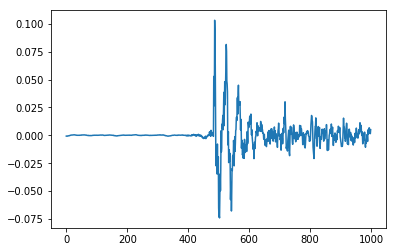

In [46]:
from matplotlib import pyplot as plt
plt.plot(y[:1000])

In [40]:
y[:100]

array([-7.3242188e-04, -7.6293945e-04, -6.4086914e-04, -7.6293945e-04,
       -7.6293945e-04, -5.7983398e-04, -5.4931641e-04, -4.8828125e-04,
       -4.8828125e-04, -3.3569336e-04, -3.0517578e-04, -3.3569336e-04,
       -1.2207031e-04,  0.0000000e+00,  6.1035156e-05,  1.2207031e-04,
        1.2207031e-04,  2.1362305e-04,  2.1362305e-04,  2.7465820e-04,
        2.1362305e-04,  2.4414062e-04,  3.0517578e-04,  3.3569336e-04,
        4.2724609e-04,  3.9672852e-04,  4.5776367e-04,  3.6621094e-04,
        3.0517578e-04,  3.3569336e-04,  2.1362305e-04,  1.8310547e-04,
        9.1552734e-05,  1.2207031e-04,  1.2207031e-04,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  3.0517578e-05,
        0.0000000e+00,  1.2207031e-04,  9.1552734e-05,  9.1552734e-05,
        9.1552734e-05,  6.1035156e-05,  2.7465820e-04,  2.4414062e-04,
        2.7465820e-04,  2.7465820e-04,  3.0517578e-04,  2.4414062e-04,
      

### Mu-law quantization

In [47]:
input1 = mulaw_encode(y)
print(input1)
print(input1.size())
output1 = input1.view(1, 1, -1)
print(output1.size())

tensor([ 124,  123,  124,  ...,  131,  129,  128], dtype=torch.int32)
torch.Size([212893])
torch.Size([1, 1, 212893])


In [48]:
#importlib.reload(util)
rev_inp = mulaw_decode(input1)
print(rev_inp)
print(y)

tensor([-0.0006, -0.0008, -0.0006,  ...,  0.0006,  0.0003,  0.0001])
[-7.3242188e-04 -7.6293945e-04 -6.4086914e-04 ...  7.3242188e-04
  2.1362305e-04  6.1035156e-05]


In [53]:
np.mean(rev_inp.numpy()-y)

1.7950957e-07

In [6]:
one_hot = util.one_hot_encode(input1, 256)
print(one_hot.size())

torch.Size([212893, 256])


In [7]:
one_hot_decode = util.one_hot_decode(one_hot)
print(one_hot_decode.size())

torch.Size([212893])


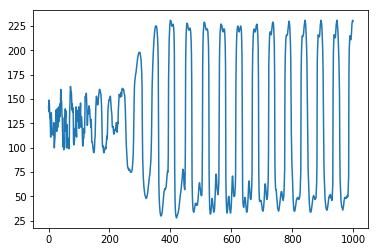

In [8]:
plt.plot(input1.numpy()[1000:2000])

In [9]:
output1.squeeze_()

tensor([ 124,  123,  124,  ...,  131,  129,  128], dtype=torch.int32)

In [10]:
in_size = 10 #size of input
piece = input1.narrow(0, 0, in_size) # Get the first 50 values
print("Size of cut: {}, input size: {}".format(in_size, piece.size()[0]))
input2 = piece.reshape(1,1, in_size).float() # conv input should be float tensor

Size of cut: 10, input size: 10


## Set up dataloader

In [3]:
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import os
import torch
import pandas as pd

In [4]:
%cd ../src/wavenet
from dataset import TextToSpeechDataset, WavenetLoader
from train import Trainer
importlib.reload(dataset)

/root/env/IDP-Luminovo/tts/src/wavenet


<module 'dataset' from '/root/env/IDP-Luminovo/tts/src/wavenet/dataset.py'>

In [5]:
%cd ../../notebooks
csv_file = "data/metadata.csv"
audio_dir = 'data/wavs'

/root/env/IDP-Luminovo/tts/notebooks


In [6]:
TTSDataset = TextToSpeechDataset(csv_file, audio_dir )

data/metadata.csv


In [15]:
print(TTSDataset.text_frames.iloc[0,2:])

2    Printing, in the only sense with which we are ...
Name: 0, dtype: object


In [16]:
item = TTSDataset[1]
text = item['text']
print(type(text))
audio=item['speech']
print(type(audio))
mulaw = util.mulaw_encode(audio)
print(mulaw.size())
quantize = util.one_hot_encode(mulaw)
print(quantize.size())
dequantize = util.one_hot_decode(quantize)
print(dequantize.size())
demulaw = util.mulaw_decode(dequantize)
print(demulaw.size())

print(audio)
print(demulaw)

import IPython.display as ipd
print(text)
ipd.Audio(audio, rate=22050)

<class 'list'>
<class 'numpy.ndarray'>
torch.Size([41885])
torch.Size([41885, 256])
torch.Size([41885])
torch.Size([41885])
[-0.00027466  0.          0.         ... -0.00088501 -0.00097656
 -0.00109863]
tensor([-0.0003,  0.0001,  0.0001,  ..., -0.0008, -0.0011, -0.0011])
['in being comparatively modern.']


In [17]:
dataloader = torch.utils.data.DataLoader(TTSDataset, batch_size=1)
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['text'][0], sample_batched['speech'].shape)
    if i_batch == 2:
        break

0 ('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',) torch.Size([1, 212893])
1 ('in being comparatively modern.',) torch.Size([1, 41885])
2 ('For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process',) torch.Size([1, 213149])


In [18]:
net = wave_model.WavenetModel()
print('receptive field: ', wavenet.receptive_field)

NameError: name 'wave_model' is not defined

In [9]:
receptive_length = wavenet.receptive_field
output_length = 16
input_length = receptive_length - 1 + output_length
print(input_length)

19


In [10]:
wavenet_loader = WavenetLoader(TTSDataset, receptive_length, input_length, batch_size=1)
print(wavenet_loader)

In [11]:
%cd ../src/wavenet
from dataset import TextToSpeechDataset, WavenetLoader
from train import Trainer
importlib.reload(dataset)
%cd ../../notebooks
csv_file = "data/metadata.csv"
audio_dir = 'data/wavs'

/root/env/IDP-Luminovo/tts/src/wavenet
/root/env/IDP-Luminovo/tts/notebooks


In [22]:
k = 0
lr = 0.001
wd = 0
optim = torch.optim.Adam(params=wavenet.parameters(), lr=lr, weight_decay=wd)
for d in wavenet_loader:
    for x, target in d:
        x = x.float()
        x = Variable(x)
        #print("x: ",x.size())
        x, target = Variable(x), Variable(target)
        target = Variable(target.long())
        #print("target: ", target.size())
        y = wavenet(x)
        y = y.view(-1, 256) # number of channels
        #print("y:", y.size())
        loss = F.cross_entropy(y.squeeze(), target.squeeze())
        #print("loss: ", loss)
        optim.zero_grad()
        loss.backward()
        #loss = loss.data[0]
        optim.step()
        
        k += 1
        if k == 3: break
        if k % 10000:
            print(loss)
    break            

tensor(5.6866)
tensor(5.4444)


## Build the trainer

In [12]:
lr = 0.001
wd = 0
WaveTrainer = Trainer(wavenet, TTSDataset, lr)
WaveTrainer.train(num_epochs=1)

hey
Epoch: 0


KeyboardInterrupt: 

## Add the generator 

In [15]:
print(wavenet.generate(50))

tensor([[[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,  100.,  100.,  100.,  100.,  100.,
           100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
           100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
           100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
           100.,  100.]]])


In [24]:
print(input_length)
print(receptive_length)
print(output_length)
init = np.zeros(input_length)
init = torch.tensor(init).float().view(1, 1, -1)

while init.size(-1) != 40:
    x = init[:, :, -input_length:]
    gen_out = wavenet(x)
    last = gen_out[:,:,-1]
    decoded = util.one_hot_decode(last)
    init = torch.cat((init.float(), decoded.float().view(1,1,-1)),2)
    #print(init[:, :, -input_length:])

print(init)

19
4
16
tensor([[[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,  200.,   16.,   16.,   16.,   16.,
            16.,   16.,   16.,   16.,   16.,   16.,   16.,   16.,
            16.,   16.,   16.,   16.,   16.,   16.,   16.,   16.]]])
